This jupyter notebook shall serve as accompanying material to the paper titled "Using Computational Methods to Discover Novel Drugs for the Treatment of Androgenetic Alopecia", a report for the "Computational Structural Biology for Lead Discovery" subject at UPM's Master in Computational Biology

## Imports

First, we proceed to import the modules we will use:

In [1]:
import json                        # Lets us work with the json format
import requests                    # Allows Python to make web requests
import pandas as pd                # Analysis of tabular data
import numpy as np                 # Numerical library
import matplotlib.pyplot as plt    # Static, animated, and interactive visualizations

import rdkit                       # Cheminformatics and ML package
from rdkit.Chem import MACCSkeys   # MACCS fingerprint calculation
from rdkit.Chem import PandasTools # RDkit interaction with pandas
from rdkit.Chem import rdFingerprintGenerator #Generate fingerprints
from rdkit import Chem             # The chemistry library
from rdkit.Chem import Descriptors, Draw # Molecule descriptors for the Ro5
import rdkit.Chem.AllChem as AllChem # Import all RDKit chemistry modules

## Initial Analysis

First, we query the compounds targeting **CHEMBL1856** (3-oxo-5-alpha-steroid 4-dehydrogenase 2, a.k.a. 5-$\alpha$-reductase type II

In [2]:
# Ask for at least 150 compounds
activity_url = "https://www.ebi.ac.uk/chembl/api/data/activity?target_chembl_id_exact=CHEMBL1856&offset=150&limit=150"
# Get results as JSON
activity_request = requests.get(activity_url, headers={"Accept":"application/json"}).json()
# Display as table
activity_table = pd.DataFrame.from_dict(activity_request['activities'])[['molecule_chembl_id', 
                                                                         'type', 'standard_value', 'standard_units']]

We then process the data by Ki and standarize the values

In [3]:
# Select only those that have Ki
activity_table_filter = activity_table.loc[activity_table['type']=="Ki"].copy().dropna()
# Transform the standard_value column to float to be able to work with it
activity_table_filter['standard_value'] = activity_table_filter['standard_value'].astype("float")
# Order the table by value and display first 5 values
activity_table_filter.sort_values(['standard_value']).head(5)

,molecule_chembl_id,type,standard_value,standard_units
143,CHEMBL336532,Ki,7.6,nM
21,CHEMBL3350133,Ki,44.0,nM
140,CHEMBL340006,Ki,46.0,nM
25,CHEMBL3350133,Ki,110.0,nM
141,CHEMBL340006,Ki,265.0,nM


We find the best compound to be CHEMBL296415. After [checking CHEMBL](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL296415/), we find no information on selectivity; since we want it to be selective, we search for approved, selective drugs:

In [4]:
# Specify approved drugs that target CHEMBL1856
mechanism_url = "https://www.ebi.ac.uk/chembl/api/data/mechanism?target_chembl_id__exact=CHEMBL1856"
# Get data from the URL
mechanism_components = requests.get(mechanism_url, headers={"Accept":"application/json"}).json()
# Format dataframe
mechanism_table = pd.DataFrame.from_dict(mechanism_components['mechanisms'])[['molecule_chembl_id', 'max_phase']]
mechanism_table #And print

,molecule_chembl_id,max_phase
0,CHEMBL710,4


We find there is only one approved compound, Finasteride (**CHEMBL710**). Our focus will thus be finding drugs similar to Finasteride, but more effective, more selective, and with less side effects.

## Similarity Analysis

We upload FNS's SMILES TO [SwissSimilarity](http://www.swisssimilarity.ch/), select ChEMBL (activity<10µM) as subset and combined as method, run the analysis and save the result as "ScreeningResultsFinasteride.csv".

## Ligand Based Virtual Screening

We subset this data to get only the results most similar to FNS, using a series of metrics (DICE/Tanimoto, MACCS/Morgan) explained in the paper.

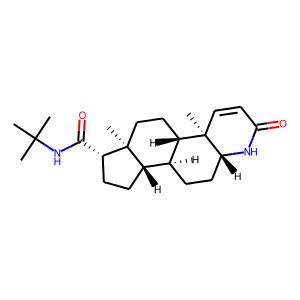

In [5]:
# Define Query molecule
smiles = "CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(=O)C=C[C@]4(C)[C@H]3CC[C@]12C"
Query = rdkit.Chem.MolFromSmiles(smiles)
# And depict it
rdkit.Chem.Draw.MolToImage(Query, includeAtomNumbers=True)

In [6]:
raw_database = pd.read_csv('./ScreeningResultsFinasteride.csv', delimiter=';', 
                           names =('ChemblID','Score','Smile'))       # Read the file and add titles
print(f"The initial compounds database has {len(raw_database)} molecules")
PandasTools.AddMoleculeColumnToFrame(raw_database, smilesCol='Smile') # Generate molecule (RoMol) from SMILES

The initial compounds database has 400 molecules


Now, we will build databases for our fingerprints:

In [7]:
# We build databases for the two methods
MACCSDatabase = raw_database.ROMol.apply(MACCSkeys.GenMACCSKeys)
MorganDatabase = rdFingerprintGenerator.GetFPs(raw_database["ROMol"].tolist())

# And prepare the queries:
MorganQuery = rdFingerprintGenerator.GetFPs([Query])[0]
MACCQuery = MACCSkeys.GenMACCSKeys(Query)

And we calculate the indices based on those fingerprints:

In [8]:
# We calculate this indices both for the MACCS fingerprints
raw_database["Tanimoto (MACCS)"] = rdkit.DataStructs.BulkTanimotoSimilarity(MACCQuery, MACCSDatabase)
raw_database["Dice (MACCS)"] = rdkit.DataStructs.BulkDiceSimilarity(MACCQuery, MACCSDatabase)
# And for the morgan fingerprint too
raw_database["Tanimoto (Morgan)"] = rdkit.DataStructs.BulkTanimotoSimilarity(MorganQuery, MorganDatabase)
raw_database["Dice (Morgan)"] = rdkit.DataStructs.BulkDiceSimilarity(MorganQuery, MorganDatabase)

We can describe the new database:

In [9]:
raw_database.describe()

,Score,Tanimoto (MACCS),Dice (MACCS),Tanimoto (Morgan),Dice (Morgan)
count,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.055978,0.482113,0.640505,0.157272,0.258770
std,0.099914,0.130162,0.115564,0.108950,0.140409
min,0.025000,0.205128,0.340426,0.035294,0.068182
25%,0.027750,0.388682,0.559785,0.093458,0.170940
50%,0.030000,0.450806,0.621456,0.113636,0.204082
75%,0.038000,0.600000,0.750000,0.172580,0.294359
max,0.998000,1.000000,1.000000,1.000000,1.000000


As we can see, the simmilarity scores are pretty small, but this is to be expected when selecting "Combined - ChEMBL (activity<10µM)" in ENSEMBL, as it takes two methods (electroshape and fingerprint) which are quite different. For our Tanimoto and Dice metrics, we can see that all metrics including MACCS yield way better values than those used with the Morgan fingerprint, and those with Dice show better results than those with Tanimoto. Thus, we use "dice_maccs" as our parameter, and set the cutoff to 0.621456 (with a length of ~200 elements and representing Quartile 2) and save the data.

In [10]:
raw_databasefilter = raw_database.loc[raw_database['Dice (MACCS)'].astype('float') > 0.621456]
raw_databasefilter.drop('ROMol', axis=1).to_csv('./SimilarityAnalysisFinasteride.csv', index=False)
print(f"The DICE(MACCS) filtered database has {len(raw_databasefilter)} molecules")

The DICE(MACCS) filtered database has 200 molecules


## Pharmacophore Based Virtual Screning

We upload "SimilarityAnalysisFinasteride.csv" to Pharmit, and generate the "Finasteride-Similar 5ARIs KQMJ9Y" database. Since PharmIt requires the db format to be ".smi", we make the necessary changes:

In [11]:
pharmit_input = raw_databasefilter['Smile'] + ' ' + raw_databasefilter['ChemblID']
pharmit_input.to_csv('./pharmit_input.smi', index=False, header=False)

We use our created pharmacophore (see paper) to filter the database, and download the results as "pharmit_output.sdf"

## ADMET Properties analysis

As a proxy for ADMET properties, we are using Lipinski's rule of five, adding TPSA as an additional method.

In [12]:
def calculate_ro5_properties(smiles): # Define the funtion to validate Ro5
    molecule = Chem.MolFromSmiles(smiles)
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    TPSA = Descriptors.TPSA (molecule)
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, TPSA < 140]
    ro5_fulfilled = sum(conditions) == 5 
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, TPSA, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA", "ro5_fulfilled"],
    )

Read the database we will process:

In [13]:
MoleculeDatabase = PandasTools.LoadSDF('./pharmit_output.sdf', embedProps=True, molColName=None, smilesName='smiles')
print(f"The pharmit database has {len(MoleculeDatabase)} molecules")

The pharmit database has 51 molecules


And apply the Rule of Five

In [14]:
# Calculate RO5 properties for all molecules
ro5_properties = MoleculeDatabase["smiles"].apply(calculate_ro5_properties)

# Concat the properties dataframe with the pharmit output dataframe
MoleculeDatabase_Concat = pd.concat([MoleculeDatabase, ro5_properties], axis=1)

#And separate by valid and invalid drugs (~ negates boolean values)
MoleculeDatabase_ro5_fulfilled = MoleculeDatabase_Concat[MoleculeDatabase_Concat["ro5_fulfilled"]]
MoleculeDatabase_ro5_violated = MoleculeDatabase_Concat[~MoleculeDatabase_Concat["ro5_fulfilled"]]
print(f"{len(MoleculeDatabase_ro5_fulfilled)} Ro5-following compounds found")

30 Ro5-following compounds found


We save Ro5-fulfilling compounds for refference:

In [15]:
MoleculeDatabase_ro5_fulfilled.to_csv("MolDB_Ro5.csv", index=False)

## Docking using DockThor (Autodock Vina)

For autodock vina, we want to screen the most similar molecules to our pharmacophore to see how these bind to our original targets. We can get the 4 best hits like so:

In [16]:
MoleculeDatabase_ro5_fulfilled.sort_values(['rmsd'], ascending=False).head(4)

,rmsd,ID,smiles,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
33,0.60144037,CHEMBL2397139,CNC(=O)c1ccc(OC2CCC(NC(=O)NC34CC5CC(CC(C5)C3)C...,425.267842,3,3,4.00420,79.46,True
23,0.551425219,CHEMBL1668930,CC(=O)N1CCC(NC(=O)NC2CCC(C)(C)CC2)CC1,295.225977,2,2,2.26530,61.44,True
17,0.547150791,CHEMBL2282650,CC1=C2N(C)CC3C(CCC4(C)C(C(=O)NC(C)(C)C)CCC34)C...,400.308979,3,1,4.54840,49.41,True
46,0.510232747,CHEMBL1631395,CC(=O)Nc1cc2c3c(c1)n(C/C=C/Cn1cc(C)c(=O)[nH]c1...,409.175004,7,2,1.12242,110.89,True


And we process them using Autodock Vina. Unfortunately, this are not valid molecules (see paper). So, we process the full database to get one in SDF format for DockThor

In [17]:
pd.options.mode.chained_assignment = None # Disable warnings
# Subset only the eseential columns
MoleculeDatabase_ro5_fulfilled.reset_index(inplace=True)
MitDatabase = MoleculeDatabase_ro5_fulfilled[['ID','smiles']]
# We add the molecule column using rdkit
PandasTools.AddMoleculeColumnToFrame(MitDatabase,'smiles','Molecule')
# And add Hidrogens to said molecules
MitDatabase['MoleculeH'] = MitDatabase['Molecule'].apply(Chem.AddHs)
# Compute 3D coordinates
MitDatabase['MoleculeH'].map(AllChem.EmbedMolecule);

And we save it:

In [18]:
PandasTools.WriteSDF(MitDatabase, 'Finasteride_Similar_Ro5.sdf', 
                     molColName='MoleculeH', properties=list(MitDatabase.columns))

We can now read the results and process them:

In [19]:
# Load dataframes
bestranking_typeII = pd.read_csv('./bestranking_typeII.csv', delimiter=';', header=0) 
bestranking_typeI  = pd.read_csv('./bestranking_typeI.csv',  delimiter=';', header=0) 

# For each database, get the compound ID and select the Name and Score columns
for i, row in bestranking_typeII.iterrows(): bestranking_typeII['Name'][i] = bestranking_typeII['Name'][i].split('_')[-1]
bestranking_typeII = bestranking_typeII[['Name', 'Score']]

# For each database, get the compound ID and select the Name and Score columns
for i, row in bestranking_typeI.iterrows(): bestranking_typeI['Name'][i] = bestranking_typeI['Name'][i].split('_')[-1]
bestranking_typeI = bestranking_typeI[['Name', 'Score']]

# We rename the columns
bestranking_typeII.rename(columns = {'Score':'Score for type II'}, inplace = True)
bestranking_typeI.rename(columns = {'Score':'Score for type I'}, inplace = True)

# Merge the two dataframes
bestranking = pd.merge(bestranking_typeI, bestranking_typeII, how='inner', on = 'Name')

# Add CHEMBLIDs
for i, row in bestranking.iterrows(): 
    bestranking['Name'][i] = MoleculeDatabase_ro5_fulfilled.iloc[int(row["Name"])]['ID']
    
# And convert scores to Ki
bestranking["KI for type I"] = np.exp(-bestranking["Score for type I"]/(0.008314*(273+37)))
bestranking["KI for type II"] = np.exp(-bestranking["Score for type II"]/(0.008314*(273+37)))

Now, we select only those CHEMBLIDs that are more effective and selective than finasteride:

In [20]:
initial_ki = float(bestranking.loc[bestranking["Name"]=="CHEMBL710"]["KI for type I"])
bestranking.loc[(bestranking["KI for type I"] >= initial_ki) & (bestranking["KI for type II"] <= initial_ki)]

,Name,Score for type I,Score for type II,KI for type I,KI for type II
0,CHEMBL2057291,-10.082,-8.657,49.988102,28.757235
2,CHEMBL1343539,-9.619,-8.498,41.768499,27.036773
3,CHEMBL2282650,-9.608,-8.746,41.590612,29.767617
4,CHEMBL2057296,-9.581,-8.565,41.157187,27.748830
5,CHEMBL76192,-9.507,-8.255,39.992294,24.604138
6,CHEMBL2282653,-9.351,-8.616,37.643461,28.303388
7,CHEMBL1762030,-9.271,-8.796,36.492965,30.350742
8,CHEMBL2282652,-9.252,-8.281,36.224930,24.853599
9,CHEMBL1668930,-9.204,-7.939,35.556526,21.765096
10,CHEMBL1631395,-9.186,-8.164,35.309066,23.750579


Since there are a lot of compounds, we can select those that are better among equals:

In [21]:
bestranking.loc[(bestranking["KI for type I"] >= (initial_ki + 0.15*initial_ki )) & 
                 (bestranking["KI for type II"] <= (initial_ki - 0.15*initial_ki))]

,Name,Score for type I,Score for type II,KI for type I,KI for type II
5,CHEMBL76192,-9.507,-8.255,39.992294,24.604138
8,CHEMBL2282652,-9.252,-8.281,36.224930,24.853599
9,CHEMBL1668930,-9.204,-7.939,35.556526,21.765096


The discussion can be checked in the paper! :P